## Import libraries

In [1]:
import pandas as pd
from collections import defaultdict
from transformers import pipeline
from tqdm import tqdm
import pickle
import sklearn
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import scikitplot as skplt


In [2]:
!pip install -U scikit-learn
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 22.2 MB 22.7 MB/s            
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


## Import clean tweets

In [2]:
df = pd.read_csv("./csv/df_glarner_translated_tweets_clean.csv")

In [3]:
df

,Unnamed: 0,tweets,time,language,translated_tweets
0,0,Man sollte die armen Schüler vor seinen Texten...,2022-12-18 07:40:38+00:00,"((0, 58, 'GERMAN', 'de'),)",One should protect the poor students from his ...
1,1,Ein FDP-ler fordert flächendeckend Tempo 30 .....,2022-12-18 07:32:44+00:00,"((0, 81, 'GERMAN', 'de'),)",An FDP-ler is calling for full speed 30 ... re...
2,2,will ein verdientes Mitglied im Swisscom-VR in...,2022-12-17 06:32:27+00:00,"((0, 219, 'GERMAN', 'de'),)",A well-deserved member of the Swisscom-VR want...
3,3,Zufällig gesehen … ist das echt die beste Mod...,2022-12-17 04:47:11+00:00,"((0, 84, 'GERMAN', 'de'),)",By chance... is this really the best presenter...
4,4,Die Armee gehört an die Grenze! Was heute besc...,2022-12-16 11:18:43+00:00,"((0, 185, 'GERMAN', 'de'),)",The army belongs to the border! What was decid...
...,...,...,...,...,...
1255,1255,Auf dem direkten Weg zur Zehn-Millionen-Schweiz,2020-02-01 14:18:16+00:00,"((0, 47, 'GERMAN', 'de'),)",On the direct way to ten-million-Switzerland
1256,1256,"Oh, die FDP entdeckt, was wir seit Jahren krit...",2019-11-28 09:56:18+00:00,"((0, 54, 'GERMAN', 'de'),)","Oh, the FDP discovers what we've been criticiz..."
1257,1257,Es gibt tatsächlich einen „Eritreischen Medien...,2019-10-16 15:15:05+00:00,"((0, 57, 'GERMAN', 'de'),)","There is indeed a ""Eritrean Media League""?"
1258,1258,Das schreibt ausgerechnet welcher wegen eines...,2019-04-10 08:37:47+00:00,"((0, 86, 'GERMAN', 'de'),)",That's the one who's been convicted of a hate ...


## Create topics to keywords

In [4]:
topics_to_keyword = {}
topics_to_keyword['family'] = {'pension', 'AHV', 'AVS', 'benefit', 'benefits', 'childcare', 'nursery', 'paternity', 'pension', 'life expectancy', 'social assistance', 'social housing', 'construction', 'public housing'}
topics_to_keyword['health'] = {'health', 'premium', 'organ', 'donation', 'vaccine', 'vaccination', 'insurance', 'premium', 'subsidies', 'cost brake', 'health care cost'}
topics_to_keyword['education'] = {'education', 'courses', 'subsidies', 'religion', 'sex education', 'reconversion', 'learning', 'school', 'highschool', 'apprenticeship', 'disabilities'}
topics_to_keyword['immigration'] = {'resident', 'communal elections', 'bilateral', 'EU', 'immigration', 'foreigners', 'undocumented', 'residence', 'migrants', 'asylum', 'naturalisation', 'integration'}
topics_to_keyword['finances'] = {'taxes', 'financial equalisation', 'individual taxation', 'married', 'company taxation'}
topics_to_keyword['economy'] = {'electricity', 'wage', 'FDI', 'investment controls', 'takeovers', 'opening hours', 'shops', 'dismissal', 'workers', ' public services', 'post office'}
topics_to_keyword['digitalisation'] = {'Uber', 'Airbnb', 'online'}
topics_to_keyword['energy'] = {'fossil', 'fuel', 'C02', 'gas', 'renewable', 'energy', 'motorway', 'lanes', 'road pricing'}
topics_to_keyword['ecology'] = {'predators', 'lynx', 'bears', 'wolf', 'plants', 'genetically modified', 'ecologica', 'farms', 'pesticides', 'biodiversity', 'animals', 'livestock'}
topics_to_keyword['politics'] = {'campaigns', 'transparency', 'e-voting', 'votes', 'voting age'}
topics_to_keyword['security'] = {'border control', 'civil service', 'schengen', 'shengen', 'war', 'weapons', 'army', 'aircraft', 'dna'}
topics_to_keyword['external_relations'] = {'EU', 'trade', 'USA', 'human rights', 'environment', 'security council'}
topics_to_keyword['society'] = {'cannabis', 'homosexual', 'gay', 'lesbian', 'reproduction', 'equality', 'salaries', 'doctor', 'euthanasia'}



In [5]:
#save it to pickle
with open('topics.pickle', 'wb') as handle:
    pickle.dump(topics_to_keyword, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [6]:
#assign topics to tweets
classes = [set() for _ in range(len(df))]

for i,tweet in enumerate(df["translated_tweets"]):
    for topic in topics_to_keyword:
        for keyword in topics_to_keyword[topic]:
            if keyword in tweet:
                classes[i].add(topic)
        

In [7]:
df["topic"] = classes

### how many sentences without a topic?

In [8]:
res = 0
for topic in df['topic']:
    if len(topic) == 0:
        res += 1

print(res)
# many sentences without topic

1078


# Import questions and create context tweets

In [11]:
df

,Unnamed: 0,tweets,time,language,translated_tweets,topic
0,0,Man sollte die armen Schüler vor seinen Texten...,2022-12-18 07:40:38+00:00,"((0, 58, 'GERMAN', 'de'),)",One should protect the poor students from his ...,{}
1,1,Ein FDP-ler fordert flächendeckend Tempo 30 .....,2022-12-18 07:32:44+00:00,"((0, 81, 'GERMAN', 'de'),)",An FDP-ler is calling for full speed 30 ... re...,{}
2,2,will ein verdientes Mitglied im Swisscom-VR in...,2022-12-17 06:32:27+00:00,"((0, 219, 'GERMAN', 'de'),)",A well-deserved member of the Swisscom-VR want...,{}
3,3,Zufällig gesehen … ist das echt die beste Mod...,2022-12-17 04:47:11+00:00,"((0, 84, 'GERMAN', 'de'),)",By chance... is this really the best presenter...,{}
4,4,Die Armee gehört an die Grenze! Was heute besc...,2022-12-16 11:18:43+00:00,"((0, 185, 'GERMAN', 'de'),)",The army belongs to the border! What was decid...,{security}
...,...,...,...,...,...,...
1255,1255,Auf dem direkten Weg zur Zehn-Millionen-Schweiz,2020-02-01 14:18:16+00:00,"((0, 47, 'GERMAN', 'de'),)",On the direct way to ten-million-Switzerland,{}
1256,1256,"Oh, die FDP entdeckt, was wir seit Jahren krit...",2019-11-28 09:56:18+00:00,"((0, 54, 'GERMAN', 'de'),)","Oh, the FDP discovers what we've been criticiz...",{}
1257,1257,Es gibt tatsächlich einen „Eritreischen Medien...,2019-10-16 15:15:05+00:00,"((0, 57, 'GERMAN', 'de'),)","There is indeed a ""Eritrean Media League""?",{}
1258,1258,Das schreibt ausgerechnet welcher wegen eines...,2019-04-10 08:37:47+00:00,"((0, 86, 'GERMAN', 'de'),)",That's the one who's been convicted of a hate ...,{}


In [39]:
#import csv
df_questions = pd.read_csv('./csv/glarner_questions.csv', sep=';', encoding='latin-1' )


In [40]:
#convert answers to binary
df_questions["questions"] = df_questions['questions'].str[4:-2]
df_questions.loc[df_questions['smartvote_answers'] >= 3, 'binary_smarvote_answer'] = 0
df_questions.loc[df_questions['smartvote_answers'] <= 2, 'binary_smarvote_answer'] = 1

In [41]:
topics = ["family", "health", "education", "immigration", "finances", "economy", "digitalisation", "energy", "ecology", "politics", "security", "external_relations", "society"]

In [42]:
tweets_with_topic = defaultdict(list)

In [43]:
for i in range(len(df)):
    if df.iloc[i]['topic']:
        for topic in df.iloc[i]['topic']:
            tweets_with_topic[topic].append(df.iloc[i]['translated_tweets'])
        

In [44]:
context_tweets = {}

In [45]:
#join context tweets
for topic in topics:
    context_tweets[topic] = ''.join(tweets_with_topic[topic])

In [53]:
df_questions

,questions,smartvote_answers,Simplified question,Unnamed: 3,Topic,Keywords,binary_smarvote_answer
0,tes-vous favorable à une hausse de l'âge de la...,1,''Are you in favour of raising the retirement ...,NaN,Family,pension; AHV; AVS,1.0
1,'État devrait-il renforcer son soutien financi...,4,''Should the state support childcare? '',NaN,Family,benefit; childcare; nursery,0.0
2,ne initiative demande l'instauration d'un cong...,4,''Are you in favour of a paternity leave?'',NaN,Family,paternity; leave,0.0
3,es rentes de la caisse de pension doivent-elle...,4,''Should the finance state pension funds?'',NaN,Family,pension; life expectancy,0.0
4,outenez-vous les efforts au niveau des cantons...,1,''Are you in favor of benefits?'',NaN,Family,benefits; social assistance,1.0
5,a Confédération devrait-elle encourager davant...,4,''Are you in favor of public housing?'',NaN,Family,social housing; construction; public housing,0.0
6,es personnes assurées devraient-elles contribu...,4,''Should the health insurance cost more'',NaN,Health,health cost; health care cost; premium,0.0
7,pprouveriez-vous le principe du consentement p...,1,''Is organ donation good?'',NaN,Health,organ; donation,1.0
8,"ne vaccination obligatoire des enfants, basée ...",4,''Should vaccines be compulsory? '',NaN,Health,vaccine; vaccination,0.0
9,ne initiative demande que les subsides aux ass...,4,''Should health be proportional to your income?'',NaN,Health,insurance; premium; subsidies,0.0


## QA model

In [47]:
qa_model = pipeline("question-answering", model = "deepset/roberta-base-squad2")
#qa_model(question = question_paternity_leave, context = context_tweets_all)

In [70]:
huggingface_answers = []
for i in tqdm(range(len(df_questions))):
    question = df_questions.iloc[i]['Simplified question']
    context = context_tweets[df_questions.iloc[i]['Topic'].lower()]
    if not context:
        huggingface_answers.append({'score':0, 'start':0, 'end':0, 'answer':'N/A'})
    else:
        huggingface_answers.append(qa_model(question = question, context = context))


100%|██████████| 60/60 [00:29<00:00,  2.02it/s]


In [71]:
huggingface_answers

[{'score': 0.18209411203861237,
  'start': 431,
  'end': 465,
  'answer': 'I would even support an IV pension'},
 {'score': 0.006305252201855183,
  'start': 431,
  'end': 465,
  'answer': 'I would even support an IV pension'},
 {'score': 0.050571974366903305,
  'start': 431,
  'end': 465,
  'answer': 'I would even support an IV pension'},
 {'score': 0.0023603409063071012,
  'start': 431,
  'end': 465,
  'answer': 'I would even support an IV pension'},
 {'score': 0.10235542058944702,
  'start': 431,
  'end': 465,
  'answer': 'I would even support an IV pension'},
 {'score': 0.050098568201065063,
  'start': 431,
  'end': 465,
  'answer': 'I would even support an IV pension'},
 {'score': 0.1582813560962677,
  'start': 644,
  'end': 681,
  'answer': "Shouldn't the doctors and politicians"},
 {'score': 0.17286546528339386,
  'start': 9,
  'end': 74,
  'answer': 'some donations and also weapons deliveries may have been diverted'},
 {'score': 0.01507563516497612,
  'start': 2584,
  'end': 265

In [72]:
df_questions["huggingface_answers"] = huggingface_answers

In [73]:
df_questions.to_csv("./csv/df_glarner_questions_context.csv" )

#0 negative
#1 positive
#2 no answers

In [75]:
df_questions_context_cami=pd.read_csv("./csv/andreas_cami_label.csv", delimiter = ';')

In [135]:
#df_questions_context_all_cami=pd.read_csv("./csv/df_questions_context_all_cami_label.csv", delimiter = ';')

In [76]:
df_questions_context_cami.iloc[28]['Simplified question']

'"Do you believe in individual taxation?"'

In [77]:
df_questions_context_cami.iloc[28]['huggingface_answers']

"{'score': 0.00042879139073193073, 'start': 0, 'end': 73, 'answer': 'Those who believe that they can stop global warming by means of CO2 taxes'}"

In [78]:
df_questions_context_cami.iloc[28]['cami_answers']

2

In [79]:
df_questions_context_cami.iloc[28]['binary_smarvote_answer']

0

In [80]:
df_questions_context_cami



,Column1,questions,smartvote_answers,Simplified question,Unnamed: 3,Topic,Keywords,binary_smarvote_answer,huggingface_answers,cami_answers
0,0,tes-vous favorable à une hausse de l'âge de la...,1,''Are you in favour of raising the retirement ...,NaN,Family,pension; AHV; AVS,1,"{'score': 0.18209411203861237, 'start': 431, '...",2
1,1,'État devrait-il renforcer son soutien financi...,4,''Should the state support childcare? '',NaN,Family,benefit; childcare; nursery,0,"{'score': 0.006305252201855183, 'start': 431, ...",2
2,2,ne initiative demande l'instauration d'un cong...,4,''Are you in favour of a paternity leave?'',NaN,Family,paternity; leave,0,"{'score': 0.050571974366903305, 'start': 431, ...",2
3,3,es rentes de la caisse de pension doivent-elle...,4,''Should the finance state pension funds?'',NaN,Family,pension; life expectancy,0,"{'score': 0.0023603409063071012, 'start': 431,...",2
4,4,outenez-vous les efforts au niveau des cantons...,1,''Are you in favor of benefits?'',NaN,Family,benefits; social assistance,1,"{'score': 0.10235542058944702, 'start': 431, '...",2
5,5,a Confédération devrait-elle encourager davant...,4,''Are you in favor of public housing?'',NaN,Family,social housing; construction; public housing,0,"{'score': 0.050098568201065063, 'start': 431, ...",2
6,6,es personnes assurées devraient-elles contribu...,4,''Should the health insurance cost more'',NaN,Health,health cost; health care cost; premium,0,"{'score': 0.1582813560962677, 'start': 644, 'e...",2
7,7,pprouveriez-vous le principe du consentement p...,1,''Is organ donation good?'',NaN,Health,organ; donation,1,"{'score': 0.17286546528339386, 'start': 9, 'en...",2
8,8,"ne vaccination obligatoire des enfants, basée ...",4,''Should vaccines be compulsory? '',NaN,Health,vaccine; vaccination,0,"{'score': 0.01507563516497612, 'start': 2584, ...",2
9,9,ne initiative demande que les subsides aux ass...,4,''Should health be proportional to your income?'',NaN,Health,insurance; premium; subsidies,0,"{'score': 0.30132776498794556, 'start': 150, '...",2


# Evaluation individual context Tweets

In [81]:
#might not make sense
sklearn.metrics.f1_score(df_questions_context_cami["binary_smarvote_answer"], df_questions_context_cami["cami_answers"], average=None)

array([0.23255814, 0.22222222, 0.        ])

In [82]:
sklearn.metrics.confusion_matrix(df_questions_context_cami["binary_smarvote_answer"], df_questions_context_cami["cami_answers"])

array([[ 5,  1, 31],
       [ 1,  3, 19],
       [ 0,  0,  0]])

[[ 5  1 31]
 [ 1  3 19]
 [ 0  0  0]]


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator


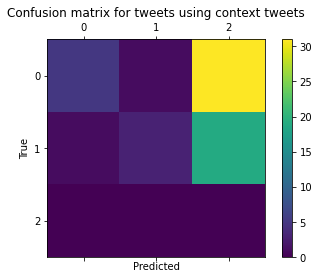

In [83]:
from sklearn.metrics import confusion_matrix

labels = ['0', '1', 2]
cm = confusion_matrix(df_questions_context_cami["binary_smarvote_answer"], df_questions_context_cami["cami_answers"])
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix for tweets using context tweets')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [98]:
# high number of unclassified, 39 as seen in the confusion matrix
#show an example from the df
#challenge: how to increase? he might not have tweeted

#otherwise for the classified, good performance
#what he says is what he thinks

### what is an unclassified tweet?

In [99]:
df_questions_context_cami.iloc[46]["Simplified question"]

'"Should biodiversity protection measures be extended?"'

In [100]:
df_questions_context_cami.iloc[46]["huggingface_answers"]

"{'score': 9.334892638435122e-06, 'start': 182, 'end': 251, 'answer': 'It is now necessary to include in the law a protection of the tenants'}"

In [101]:
df_questions_context_cami.iloc[39]["Simplified question"]

'"Should fuel be taxed?"'

In [102]:
df_questions_context_cami.iloc[39]["huggingface_answers"]

"{'score': 0.038238413631916046, 'start': 2560, 'end': 2598, 'answer': 'nuclear weapons have never been banned'}"

# Evaluation tweets all context

In [103]:
#super slow

In [104]:
#sklearn.metrics.f1_score(df_questions_context_all_cami["binary_smarvote_answer"], df_questions_context_all_cami["cami_answers"], average=None)

In [105]:
sklearn.metrics.confusion_matrix(df_questions_context_all_cami["binary_smarvote_answer"], df_questions_context_all_cami["cami_answers"])

array([[ 2,  4, 15],
       [ 2,  6, 31],
       [ 0,  0,  0]])

In [106]:
#46 unclassified, higher than individual context vector
# according to this model, carlo is not truthful

[[ 2  4 15]
 [ 2  6 31]
 [ 0  0  0]]


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator


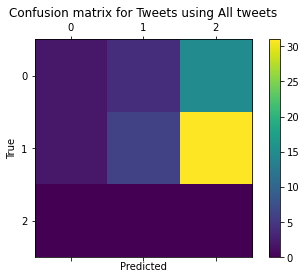

In [107]:
from sklearn.metrics import confusion_matrix

labels = ['0', '1', '2']
cm = confusion_matrix(df_questions_context_all_cami["binary_smarvote_answer"], df_questions_context_all_cami["cami_answers"])
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix for Tweets using All tweets')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Questions

1. what if carlo hasn't tweeted about a question? Then the model can't generate answers
2. suggestion to improve non-classified answers?
3. suggestion: add more keywords_to_tweets for more text in context (not sure)